In [76]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 1.3 MB/s eta 0:00:01
  Using cached patsy-0.5.1-py2.py3-none-any.whl (231 kB)
  Using cached statsmodels-0.11.1-cp37-cp37m-macosx_10_13_x86_64.whl (8.4 MB)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
import pickle
from category_encoders.cat_boost import CatBoostEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, median_absolute_error

In [3]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [4]:
train = pd.read_csv('train.csv', index_col=0, float_precision = 32).iloc[:,1:] # Remover coluna com código de inscrição
print('Train Shape:', train.shape)

test = pd.read_csv('test.csv').iloc[:,1:] # Remover coluna com código de inscrição
print('Test Shape:', test.shape)

Train Shape: (13730, 165)
Test Shape: (4576, 46)


# Pre process data

In [5]:
def preProcess(path = None, df_ = None, train = True, save = False,
               save_path = None, pipe_path = 'pipe.pkl'):
    
    # Read Data
    if df_ is None:
        df = pd.read_csv(path, index_col=0)
        if path is None:
            raise ValueError('Must Define path or DataFrame')
    else:
        df = df_.copy()
         
    # Drop when NU_NOTA_LC is null if train
    df.dropna(subset = ['NU_NOTA_LC'], inplace = True)
    
    if train:
        df.dropna(subset = ['NU_NOTA_CN', 'NU_NOTA_CH'], inplace = True)
        
        
    # Create target data if train
    if train:
        try:
            target = df['NU_NOTA_MT']
        except:         
            raise ValueError('Column NU_NOTA_MT missing from data')    
    else:  
        target = None
            
    
    # Columns to select
    cols_select = [
            'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA',
           'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ENSINO',
           'TP_DEPENDENCIA_ADM_ESC', 'CO_PROVA_CH', #'CO_PROVA_LC',
            'CO_PROVA_MT',
           'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
           'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
           'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
           'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'
                  ]
    
    # Select Columsn
    try:      
        df = df[cols_select]
    except:    
        raise ValueError('Column missing from data')
        
     
    # Columns that have floats but are categorical
#     cols_cat = [
#         'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
#         'CO_PROVA_CH', 'CO_PROVA_MT',#'CO_PROVA_LC',
#         'TP_STATUS_REDACAO'
#                ]
    

    
        
    float_cols = [
        'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1','NU_NOTA_COMP2',
        'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5','NU_NOTA_REDACAO',
        'NU_IDADE', 'TP_ANO_CONCLUIU'
    ]   
        
    # Create Pipeline floats
    pipe_float = Pipeline([
        ('inputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ])
    
    # Create Pipeline Categorical Features
    cat_cols = [
        'SG_UF_RESIDENCIA', 'TP_SEXO', 'CO_PROVA_CH',#'CO_PROVA_LC',
        'CO_PROVA_MT', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047',
        
        'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
         'TP_STATUS_REDACAO',
        'TP_LINGUA'
    ]
    
    # Convert columns
    df[cat_cols] = df[cat_cols].astype('object')
    
    pipe_cat = Pipeline([
        ('label encoder', CatBoostEncoder())
    ])
    
    # Create full pipeline
    pipe = ColumnTransformer(transformers=[
        ('pipe_float', pipe_float, float_cols),
        ('pipe_cat', pipe_cat, cat_cols)
    ]#, remainder = 'passthrough'
                            )
    
    pipe_target = Pipeline(
        [('scaler', StandardScaler())]
    )
    
    
    # Fit pipelines
    if train:
        
        pipe.fit(df, target)
        
        pipe_target.fit(target.values.reshape(-1,1))
        
        with open(pipe_path, 'wb') as f:
            
            pickle.dump([pipe, pipe_target], f)
            
    else:
        
        with open(pipe_path, 'rb') as f:
            
            pipe, pipe_target = pickle.load(f)
    
    
    # Transform variables
    df = pipe.transform(df)
    
    if train:
    
        target = pipe_target.transform(target.values.reshape(-1,1))
     
    # Save file to pickle
    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump([df, target], f)
        
    return [df, target]

# Fit models

In [6]:
def fit_models(features, target, models_path = 'models.pkl'):
    
    lm = LinearRegression()
    
    lm = lm.fit(X = features, y = target)
    
    # Store models
    models = {'Linear Model': lm}
    with open(models_path, 'wb') as f:
        pickle.dump(models, f)
        
    return models

In [7]:
def fit_model(model, x_train, x_test, y_train, y_test, **kwargs):
    
    model = model.fit(x_train, y_train, **kwargs)
    
    predictions = make_predictions_sigle(features = x_test, model = model)
    
    metrics, eval_predictions(target = y_test, predictions = predictions)
    
    return model, metrics

In [8]:
from catboost import CatBoostRegressor, Pool
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

In [329]:
!python --version

Python 3.7.0


In [314]:
!pip install numpy==1.18.1

  Using cached numpy-1.18.1-cp37-cp37m-macosx_10_9_x86_64.whl (15.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.1
    Uninstalling numpy-1.16.1:
      Successfully uninstalled numpy-1.16.1


In [321]:
!pip install pandas==0.24.0

     |████████████████████████████████| 15.9 MB 6.8 MB/s eta 0:00:011     |███████████████████████████▎    | 13.5 MB 10.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


In [324]:
!pip install cycler==0.10

In [325]:
!pip install pytz==2017.2

     |████████████████████████████████| 484 kB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2018.4
    Uninstalling pytz-2018.4:
      Successfully uninstalled pytz-2018.4


In [319]:
!pip install catboost -U

  Using cached catboost-0.23.2-cp37-none-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (10.9 MB)
  Attempting uninstall: catboost
    Found existing installation: catboost 0.22
    Uninstalling catboost-0.22:
      Successfully uninstalled catboost-0.22


In [333]:
!pip install scipy==1.1.0

  Using cached scipy-1.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (16.7 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [308]:
!pip install cython==0.28.3

     |████████████████████████████████| 5.3 MB 1.3 MB/s eta 0:00:01


In [182]:
def create_models(features, target, models_path = 'models.pkl', pipe_path = 'pipe.pkl', test_size = .25, ):
    
    models = {
        'Linear Model': LinearRegression(), 
        'Catboost': CatBoostRegressor(
            iterations = 500,
            loss_function='RMSE',
            random_state = 1,
            learning_rate=0.01,
            depth=4,
            l2_leaf_reg=0.1,
        
            ),
        'Random Forrest': RandomForestRegressor(n_estimators= 1000, max_depth = 8, random_state = 1),
        
    }
    
    kwargs = {i:{} for i in models}
    kwargs['Catboost'] = {'verbose': 0}
    
    models_fit = {}
    
    metrics = {}
    
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = test_size)
    
    with open(pipe_path, 'rb') as f:
        
        pipe, pipe_target = pickle.load(f)
        
    y_test = pipe_target.inverse_transform(y_test)
    
    for i in tqdm(models):
        
        print(f'>>>> {i}')
        
        models_fit[i] = models[i].fit(x_train, y_train, **kwargs[i])
        
        predictions = make_predictions_sigle(
            model = models_fit[i], features = x_test, transform_back_target = True, pipe_path = pipe_path)
        
        metrics[i] = eval_predictions(y_test, predictions)
        
    with open(models_path, 'wb') as f:
        
        pickle.dump(obj = [models_fit, metrics], file = f)
        
    return [models_fit, metrics]

In [36]:
kfold = KFold(n_splits=5, shuffle=True, random_state=156)

In [38]:
kfold.split(data, target)

<generator object _BaseKFold.split at 0x11c629138>

In [190]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator

In [221]:
from tpot.builtins import StackingEstimator

In [193]:
def create_models_stacking(features, target, models_path = 'models.pkl', pipe_path = 'pipe.pkl', 
                           plot = False, verbose = True, folds = 5, stack_train_split = 0.25):
    
    # Ridge
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

    e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
    alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
    alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    
    models = {
        'tpot': make_pipeline(
                StackingEstimator(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.01, loss="squared_epsilon_insensitive", tol=0.0001)),
                GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="ls", max_depth=2, max_features=0.7000000000000001, 
                                          min_samples_leaf=1, min_samples_split=17, n_estimators=100, subsample=0.35000000000000003)
            ),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=4,
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state =42),
        'Ridge': make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds)),
        'lasso': make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds)),
        'elasticnet': make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio)),
        'svr': make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,)),
        'Linear Model': LinearRegression(), 
        'Catboost': CatBoostRegressor(
            iterations = 500,
            loss_function='RMSE',
            random_state = 1,
            learning_rate=0.01,
            depth=4,
            l2_leaf_reg=0.1,
        
            ),
        'Random Forrest': RandomForestRegressor(n_estimators= 300, max_depth = 6, random_state = 1),
        
    }
    
    model_stack = CatBoostRegressor(
            iterations = 500,
            loss_function='RMSE',
            random_state = 1,
            learning_rate=0.01,
            depth=4,
            l2_leaf_reg=0.1,
        
            )
    
    kwargs = {i:{} for i in models}
    kwargs['Catboost'] = {'verbose': 0}
    
    models_fit = {}
    
    metrics = {}
    
    outfold = {}
    
    kfold = KFold(n_splits = folds, shuffle=True, random_state=156)
    
    with open(pipe_path, 'rb') as f:
        
        pipe, pipe_target = pickle.load(f)
        
    y_orig = pipe_target.inverse_transform(target).reshape(-1)
    
    predictions = {}
    
    for i in tqdm(models):
        
        print(f'>>>> {i}')
        
        models_fit[i] = []
        
        outfold[i] = []
        
        predictions[i] = y_orig.copy()
        
        for train, test in kfold.split(features, target):
        
            models_fit[i].append(models[i].fit(features[train], target[train], **kwargs[i]))

            predictions[i][test] = make_predictions_sigle(
                model = models_fit[i][-1], features = features[test],
                transform_back_target = True, pipe_path = pipe_path
            ).reshape(-1)
        
        metrics[i] = eval_predictions(y_orig, predictions[i], plot = plot, verbose = verbose)
        
    if stack_train_split is not None:
        
        x_train, x_test, y_train, y_test = train_test_split(
            pd.DataFrame(predictions), y_orig, test_size = stack_train_split)
        
        #model_stack = model_stack.fit(x_train, y_train, verbose = 0, )
        model_stack = model_stack.fit(x_train, y_train, use_best_model=True, eval_set=(x_test, y_test), verbose=False)
        
        p = make_predictions_sigle(model = model_stack, features = x_test, transform_back_target = False)
        
        metrics['stack'] = eval_predictions(y_test, p, plot = plot, verbose = verbose)
        
    with open(models_path, 'wb') as f:
        
        pickle.dump(obj = [models_fit, metrics, model_stack], file = f)
        
    return [models_fit, metrics, model_stack]

  0%|          | 0/9 [00:00<?, ?it/s]

>>>> tpot
MSE: 5114.604
RMSE: 71.516
Max Error: 445.829
Median Absolute Error: 445.829


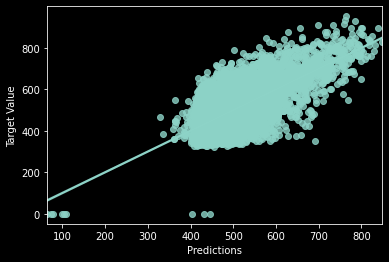

 11%|█         | 1/9 [00:09<01:14,  9.26s/it]

>>>> Gradient Boosting
MSE: 5431.428
RMSE: 73.698
Max Error: 444.096
Median Absolute Error: 444.096


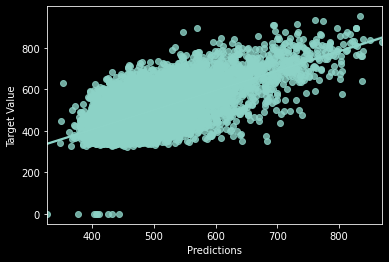

 22%|██▏       | 2/9 [00:55<02:21, 20.24s/it]

>>>> Ridge
MSE: 5487.695
RMSE: 74.079
Max Error: 439.206
Median Absolute Error: 439.206


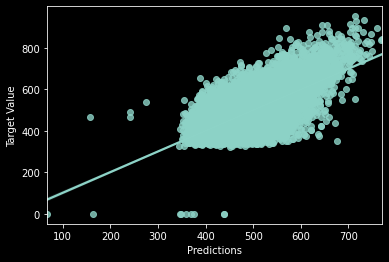

 33%|███▎      | 3/9 [00:57<01:29, 14.93s/it]

>>>> lasso
MSE: 5485.846
RMSE: 74.066
Max Error: 439.455
Median Absolute Error: 439.455


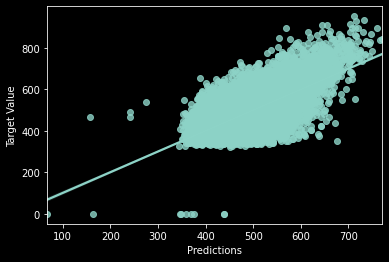

 44%|████▍     | 4/9 [00:58<00:54, 10.82s/it]

>>>> elasticnet
MSE: 5486.065
RMSE: 74.068
Max Error: 439.382
Median Absolute Error: 439.382


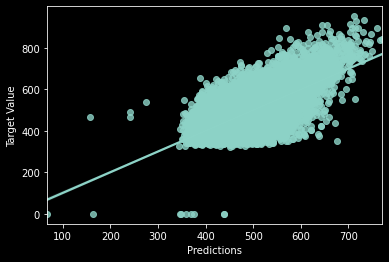

 56%|█████▌    | 5/9 [01:01<00:32,  8.23s/it]

>>>> svr
MSE: 5472.708
RMSE: 73.978
Max Error: 433.033
Median Absolute Error: 433.033


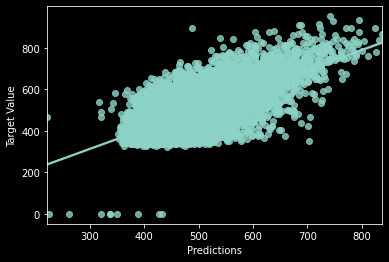

 67%|██████▋   | 6/9 [01:28<00:42, 14.07s/it]

>>>> Linear Model
MSE: 5487.911
RMSE: 74.08
Max Error: 439.318
Median Absolute Error: 439.318


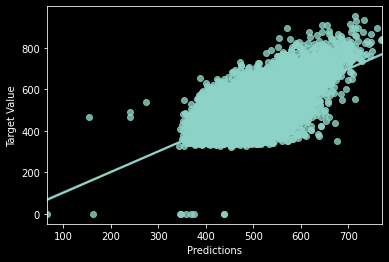

 78%|███████▊  | 7/9 [01:29<00:20, 10.17s/it]

>>>> Catboost
MSE: 5261.91
RMSE: 72.539
Max Error: 445.8
Median Absolute Error: 445.8


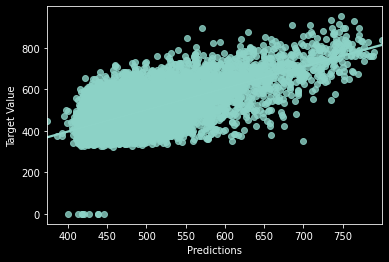

 89%|████████▉ | 8/9 [01:36<00:09,  9.24s/it]

>>>> Random Forrest
MSE: 5322.258
RMSE: 72.954
Max Error: 448.328
Median Absolute Error: 448.328


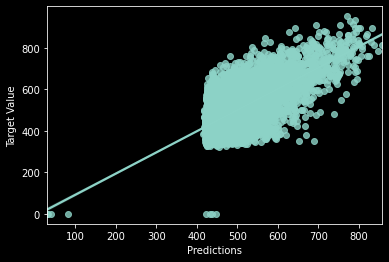

100%|██████████| 9/9 [02:11<00:00, 14.57s/it]


MSE: 5362.119
RMSE: 73.226
Max Error: 261.421
Median Absolute Error: 261.421


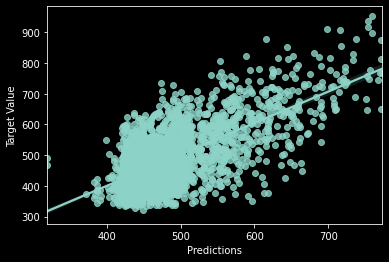

In [194]:
out = create_models_stacking(data, target, plot = True, verbose = True)

In [195]:
def make_predictions_stacking(features, models_path = 'models.pkl'):
    
    with open(models_path, 'rb') as f:
        
        models_fit, metrics, model_stack = pickle.load(file = f)
        
    predictions_base = {}
    
    for i in models_fit:
        
        predictions_base[i] = np.mean(
            [make_predictions_sigle(
                model=j, transform_back_target=True, features = features
                ) for j in models_fit[i]]
            , axis = 0).reshape(-1)
        
    return model_stack.predict(pd.DataFrame(predictions_base))

In [196]:
def make_predictions_wraper_stacking(file_path = 'test.csv', df_ = None, return_predictions = False, save_name = None,
                        models_path = 'models.pkl'):
    
    # Select the ones who missed the test
    if df_ is None:
        df = pd.read_csv(file_path, index_col='NU_INSCRICAO')
    else:
        df = df_.copy()

    zeros = df.isnull().query('NU_NOTA_LC')[[]]
    zeros['NU_NOTA_MT'] = 0
    
    # Get ID of columns to be predicted
    predictions = df[['NU_NOTA_LC']].dropna()[[]]#.index
    
    # Load data
    if df_ is None:
        features, pipe = preProcess(path = file_path, train = False)
    else:
        features, pipe = preProcess(df_ = df_, train = False)
    
    
    # Make predictions
    predictions['NU_NOTA_MT'] = make_predictions_stacking(features, models_path = 'models.pkl')
    
    predictions_full = pd.concat([zeros, predictions])
    
    if save_name is not None:
        
        predictions_full.to_csv(save_name)
        
    if return_predictions:
    
        return predictions_full

In [197]:
make_predictions_wraper_stacking(save_name='answer.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

>>>> Linear Model
MSE: 5762.041
RMSE: 75.908
Max Error: 437.702
Median Absolute Error: 437.702


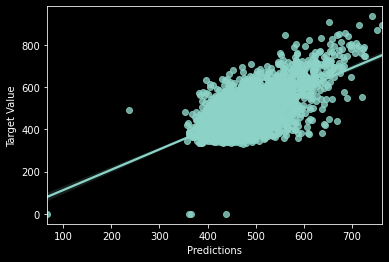

 33%|███▎      | 1/3 [00:00<00:01,  1.88it/s]

>>>> Catboost
MSE: 5607.656
RMSE: 74.884
Max Error: 444.673
Median Absolute Error: 444.673


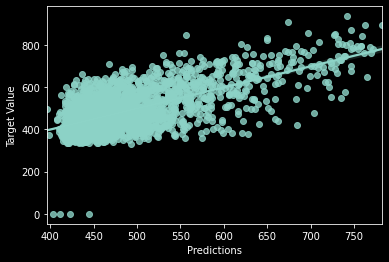

 67%|██████▋   | 2/3 [00:02<00:00,  1.14it/s]

>>>> Random Forrest
MSE: 5568.325
RMSE: 74.621
Max Error: 451.078
Median Absolute Error: 451.078


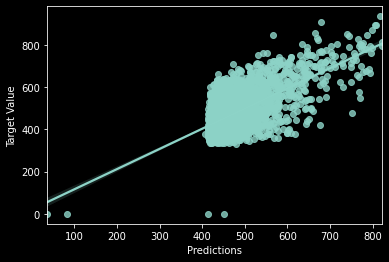

100%|██████████| 3/3 [00:29<00:00,  9.80s/it]


In [36]:
models, metrics = create_models(data, target)

In [10]:
def train_wraper(file_path = 'train.csv', return_arg = False):
    
    features, target = preProcess(path = file_path)
    
    models, metrics = create_models(features, target)
    
    if return_arg:
    
        return models, metrics
    
    

# Make Predictions

In [11]:
# Make predictions for single model
def make_predictions_sigle(features, model, pipe_path = 'pipe.pkl', transform_back_target = True):
    
    forecast = model.predict(features)
    
    with open(pipe_path, 'rb') as f:
        
        pipe, pipe_target = pickle.load(f)
        
    if transform_back_target:
        
        forecast = pipe_target.inverse_transform(forecast)
    
    return forecast
    
    

In [12]:
def predictions_ensemble(features, models, metrics = None, ensamble_method = None, pipe_path = 'pipe.pkl'):
    predictions = {}
    
    for i in models:
        
        predictions[i] = make_predictions_sigle(features, models[i], pipe_path = 'pipe.pkl', transform_back_target = True)
        
    if ensamble_method is not None:
        
        predictions = ensamble_method(predictions)
        
    return predictions
    

In [13]:
def ensamble_method(predictions):
    
    for i in predictions:
        
        if len(predictions[i].shape) > 1:
            
            predictions[i] = predictions[i].reshape(-1)
    
    return pd.DataFrame(predictions).mean(axis = 1)
    

# Eval Predictions

In [14]:
def eval_predictions(target, predictions, verbose = True, plot = True):
    
    out = {}
    
    out['MSE'] = mean_squared_error(target, predictions)
    
    out['RMSE'] = out['MSE'] ** 0.5
    
    out['MAE'] = mean_squared_error(target, predictions)
    
    out['Max Error'] = max_error(target, predictions)
    
    out['Median Absolute Error'] = median_absolute_error(target, predictions)
    
    if verbose:
        
        print(f'MSE: {round(out["MSE"],3)}')
        print(f'RMSE: {round(out["RMSE"],3)}')
        print(f'Max Error: {round(out["Max Error"],3)}')
        print(f'Median Absolute Error: {round(out["Max Error"],3)}')
        
    if plot:
        
        ax = sns.regplot(x = predictions.reshape(-1), y = target.reshape(-1), )
        
        ax.set(xlabel='Predictions', ylabel='Target Value')
        
        plt.show()
    
    
    return out

# Make full predictions

In [15]:
def make_predictions_wraper(file_path = 'test.csv', df_ = None, return_predictions = False, save_name = None):
    
    # Select the ones who missed the test
    if df_ is None:
        df = pd.read_csv(file_path, index_col='NU_INSCRICAO')
    else:
        df = df_.copy()

    zeros = df.isnull().query('NU_NOTA_LC')[[]]
    zeros['NU_NOTA_MT'] = 0
    
    # Get ID of columns to be predicted
    predictions = df[['NU_NOTA_LC']].dropna()[[]]#.index
    
    # Load data
    if df_ is None:
        features, pipe = preProcess(path = file_path, train = False)
    else:
        features, pipe = preProcess(df_ = df_, train = False)
    
    # Load models
    try:

        with open('models.pkl', 'rb') as f:
            models, metrics = pickle.load(f)
    except:

        raise ValueError('Model File Missing')
    
    # Make predictions
    predictions['NU_NOTA_MT'] = predictions_ensemble(features, models, ensamble_method = ensamble_method).values
    
    predictions_full = pd.concat([zeros, predictions])
    
    if save_name is not None:
        
        predictions_full.to_csv(save_name)
        
    if return_predictions:
    
        return predictions_full

In [160]:
file_path = 'test.csv'
make_predictions_wraper(save_name = 'answer.csv')


In [218]:
data, target = preProcess(path = 'train.csv')

In [215]:
models = fit_models(data, target)

In [233]:
pred = make_predictions_sigle(data, models[0])

In [202]:
import sys

In [205]:
sys.stdout

In [198]:
from tpot import TPOTRegressor

In [219]:
tp = TPOTRegressor(verbosity = 1, log_file = 'log.txt', population_size = 20)

In [220]:
tp_fit = tp.fit(data, target)

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.8, min_samples_leaf=1, min_samples_split=18, n_estimators=100)


In [209]:
y = tp_fit.predict(data)

In [24]:
y

array([-0.05843286, -0.42344929, -0.14842446, ..., -0.05209633,
        0.15461048,  0.28314919])

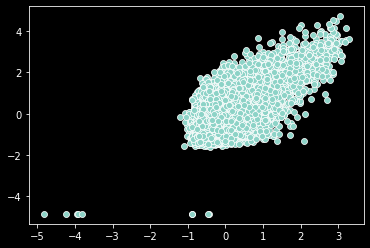

In [210]:
sns.scatterplot(y, target.reshape(-1))

In [211]:
file_path = 'test.csv'


df = pd.read_csv(file_path, index_col='NU_INSCRICAO')


zeros = df.isnull().query('NU_NOTA_LC')[[]]
zeros['NU_NOTA_MT'] = 0

# Get ID of columns to be predicted
predictions = df[['NU_NOTA_LC']].dropna()[[]]#.index

features, target = preProcess(path = file_path, train = False)


# Load models
try:

    with open('models.pkl', 'rb') as f:
        models, metrics = pickle.load(f)
except:

    raise ValueError('Model File Missing')

ValueError: Model File Missing

In [28]:
pipe_path = 'pipe.pkl'

with open(pipe_path, 'rb') as f:

    pipe, pipe_target = pickle.load(f)

In [35]:
tp_fit.export('tpot.py')

In [31]:
save_name = 'answer.csv'

# Make predictions
predictions['NU_NOTA_MT'] = pipe_target.inverse_transform(tp_fit.predict(features))

predictions_full = pd.concat([zeros, predictions])

if save_name is not None:

    predictions_full.to_csv(save_name)
